In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters


## Energy Usage Data From 2015-2024.Q1

In [2]:
usage_df = pd.read_csv('usage_15_24Q1.csv')

In [3]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
0,90001,Los Angeles County,1,2015,Residential,3872318.0,3.872318
1,90001,Los Angeles County,1,2015,Commercial,4278310.0,4.278310
2,90002,Los Angeles County,1,2015,Residential,1440786.0,1.440786
3,90002,Los Angeles County,1,2015,Commercial,505206.0,0.505206
4,90008,Los Angeles County,1,2015,Residential,439343.0,0.439343


In [4]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117702 entries, 0 to 117701
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ZipCode        117702 non-null  int64  
 1   County         117702 non-null  object 
 2   Month          117702 non-null  int64  
 3   Year           117702 non-null  int64  
 4   CustomerClass  117702 non-null  object 
 5   TotalkWh       117702 non-null  float64
 6   TotalGWh       117702 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 6.3+ MB


In [5]:
# Creating GWh field from converting kWh
usage_df['TotalGWh'] = usage_df['TotalkWh'] / 1000000

In [6]:
# Creating 'Date' column to combine Month and Year
usage_df['Date'] = usage_df['Month'].astype(str) + '-' + usage_df['Year'].astype(str)

In [7]:
usage_df['Date'] = pd.to_datetime(usage_df['Date'], format='%m-%Y')

In [8]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117702 entries, 0 to 117701
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ZipCode        117702 non-null  int64         
 1   County         117702 non-null  object        
 2   Month          117702 non-null  int64         
 3   Year           117702 non-null  int64         
 4   CustomerClass  117702 non-null  object        
 5   TotalkWh       117702 non-null  float64       
 6   TotalGWh       117702 non-null  float64       
 7   Date           117702 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 7.2+ MB


In [9]:
# Setting 'Date' as the index
usage_df = usage_df.set_index('Date')

In [10]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
Date,,,,,,,
2015-01-01,90001,Los Angeles County,1,2015,Residential,3872318.0,3.872318
2015-01-01,90001,Los Angeles County,1,2015,Commercial,4278310.0,4.278310
2015-01-01,90002,Los Angeles County,1,2015,Residential,1440786.0,1.440786
2015-01-01,90002,Los Angeles County,1,2015,Commercial,505206.0,0.505206
2015-01-01,90008,Los Angeles County,1,2015,Residential,439343.0,0.439343


In [11]:
usage = usage_df[['TotalkWh','TotalGWh']].resample('M').sum()

In [12]:
usage.head()

,TotalkWh,TotalGWh
Date,,
2015-01-31,6.599934e+09,6599.933897
2015-02-28,6.259748e+09,6259.747929
2015-03-31,5.749336e+09,5749.335961
2015-04-30,6.496674e+09,6496.673947
2015-05-31,6.478335e+09,6478.335350


In [13]:
type(usage)

pandas.core.frame.DataFrame

In [14]:
usage.describe()

,TotalkWh,TotalGWh
count,1.110000e+02,111.000000
mean,6.692054e+09,6692.054484
std,1.027503e+09,1027.502695
min,4.955070e+09,4955.070490
25%,5.967104e+09,5967.103581
50%,6.445165e+09,6445.165342
75%,7.302022e+09,7302.021859
max,9.321846e+09,9321.845731


### Plotting Energy Usage Data

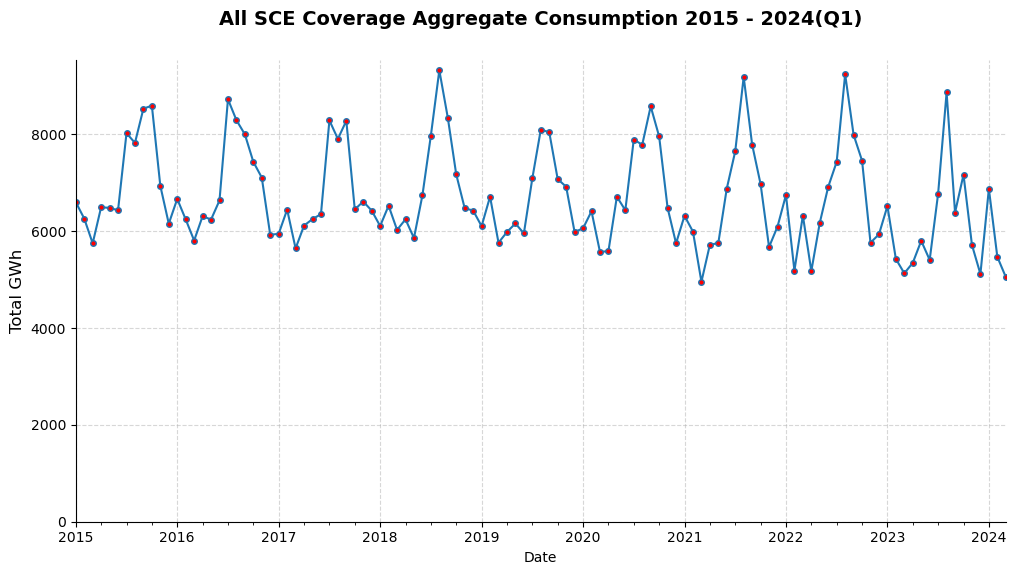

In [15]:
plt.figure(figsize=(12,6))
usage['TotalGWh'].plot(marker='o', markersize=4, markerfacecolor='red')
plt.title('All SCE Coverage Aggregate Consumption 2015 - 2024(Q1)', fontsize=14, fontweight='bold', pad=25)
plt.ylabel('Total GWh', fontsize=12)
plt.ylim(ymin=0)
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()

## Time Decomposition using STL

In [16]:
register_matplotlib_converters()
sns.set_style("darkgrid")

In [17]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

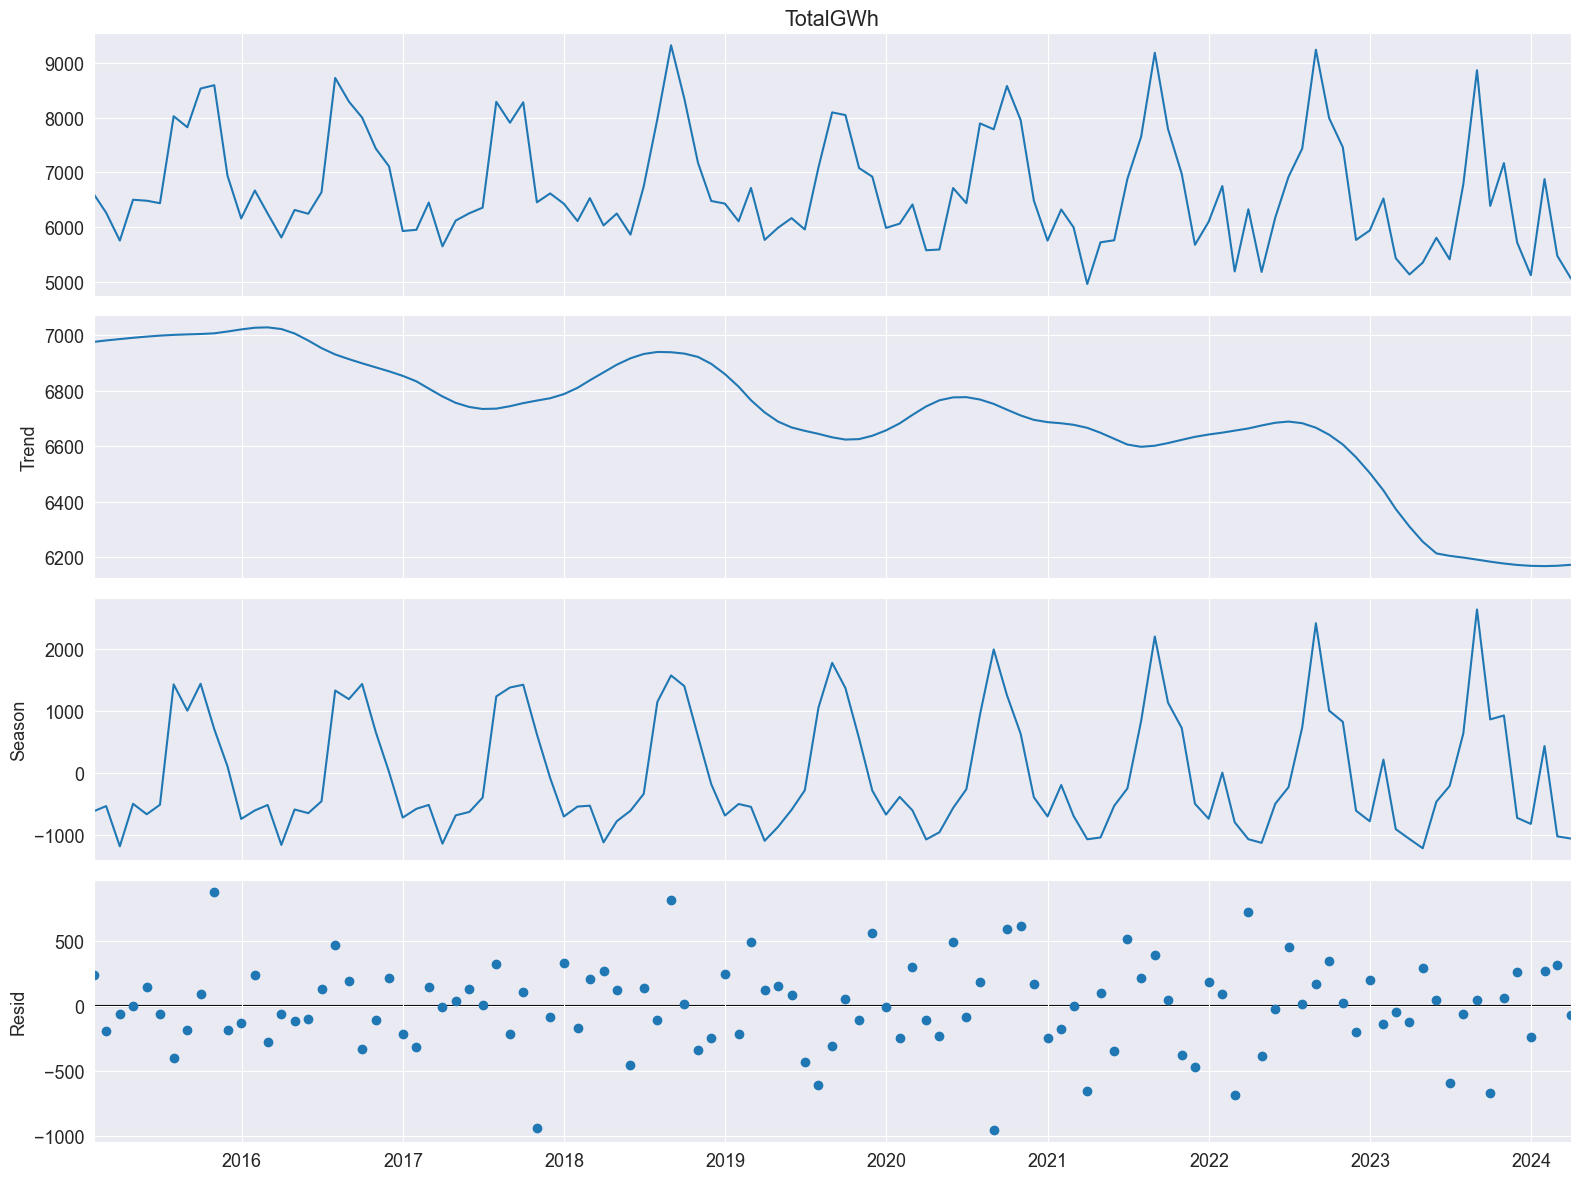

In [18]:
from statsmodels.tsa.seasonal import STL

stl = STL(usage['TotalGWh'], seasonal=13) # seasonal parameter must be odd number; default is 7
res = stl.fit()
fig = res.plot()

## Forecasting with STL

In [19]:
# Retrieving arima_inputs variable from sarimax_model_2 file containing the optimal p,d,q parameters
%store -r arima_inputs

In [20]:
arima_inputs

(2, 1, 0)

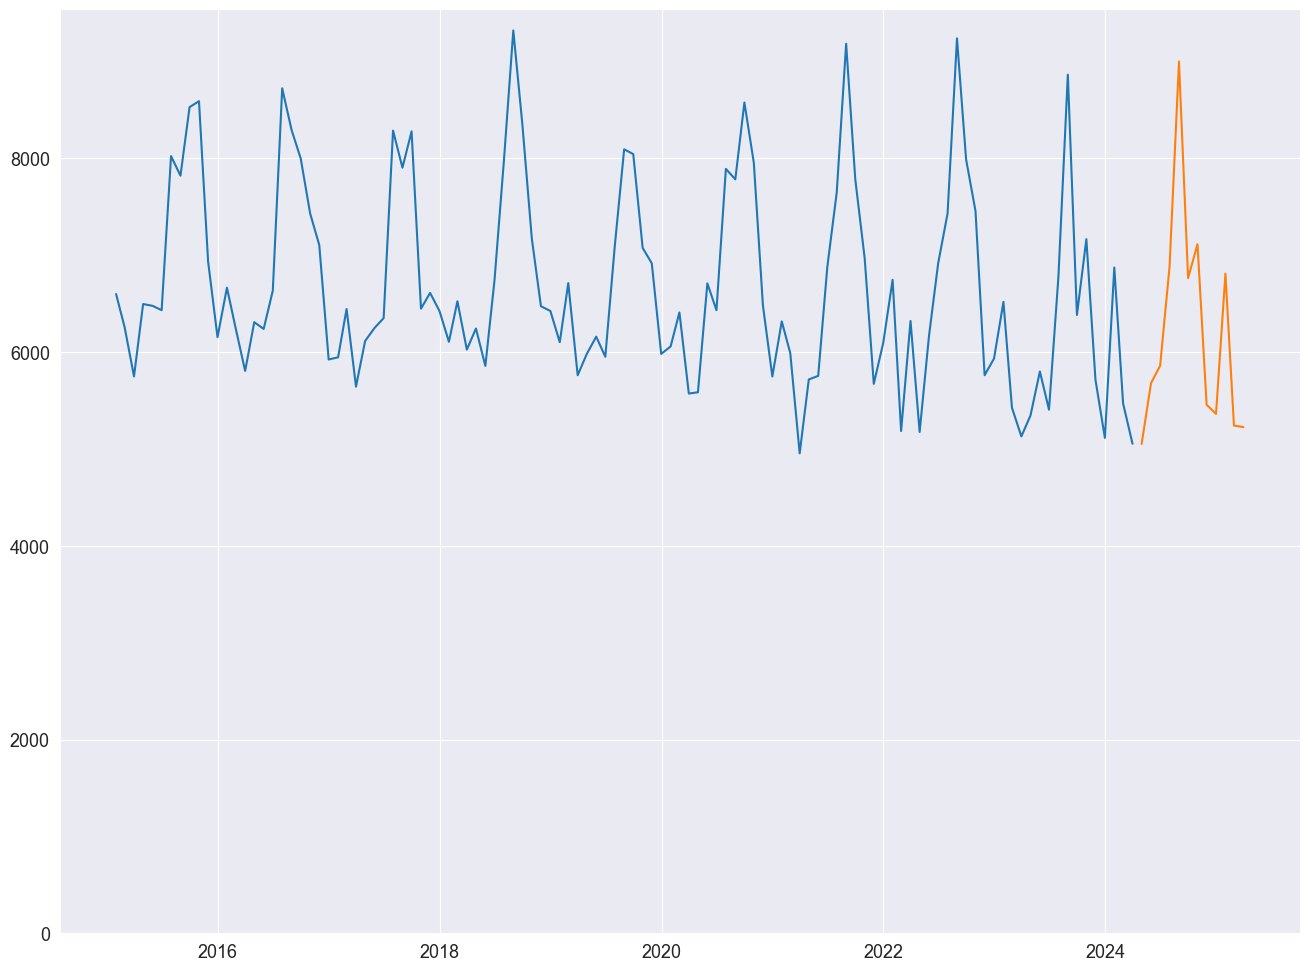

In [21]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

usage['TotalGWh'].index.freq = usage['TotalGWh'].index.inferred_freq
stlf = STLForecast(usage['TotalGWh'], ARIMA, model_kwargs=dict(order=arima_inputs))
stlf_res = stlf.fit()

forecast = stlf_res.forecast(12)
plt.plot(usage['TotalGWh'])
plt.plot(forecast)
plt.ylim(ymin=0)
plt.show()

In [22]:
print(stlf_res.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                  111
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -802.000
Date:                Mon, 22 Apr 2024   AIC                           1609.999
Time:                        21:25:44   BIC                           1618.101
Sample:                    01-31-2015   HQIC                          1613.285
                         - 03-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6703      0.084     -8.007      0.000      -0.834      -0.506
ar.L2         -0.3027      0.085     -3.547      0.000      -0.470      -0.135
sigma2      1.209e+05   1.61e+04      7.501      0.0